# To do list

- Min-Max Scaling / Standard Scaling (Distance) (v) _ 상의 필요
- if vehicleDestroys == 1  => winPlacePerc (v) _ 상의 필요
- Mode : rank, nomal, event (추후 진행할지도?)
- maxPlace와 numGroups에 대한 Feature Engineering

# 모델링 실습

1. 문제 정의
	- 이슈 파악 & 문제 도출
	- 분석 데이터 정의
	- 머신러닝 문제 정의
	- baseline을 선정

2. 데이터 수집 및 정제
	- 데이터 마트 생성
	- 데이터 정합성 평가
	- 데이터 취합
	- 데이터 포맷 통일

3. 탐색적 데이터 분석 EDA
	- 결측치 처리
	- 클래스 불균형 문제
	- 데이터 시각화
	- 통계량 분석

4. 데이터 전처리 / 피쳐엔지니어링
	- 차원의 저주
	- 상관관계 분석
	- feature 추출
	- 범주형 변수 인코딩

5. 예측 모델 개발 및 적용
	- 예측 모델 학습
	- 모델 성능 개선
	- 성능 평가
	- 최종 모델 배포

6. 결과보고서 작성
	- 시각화, 활용방안, 운영방안

- DBNOs : Number of enemy players knocked.
- assists : Number of enemy players this player damaged that were killed by teammates.
- boosts : Number of boost items used.
- damageDealt : Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills : Number of enemy players killed with headshots.
- heals : Number of healing items used.
- Id : Player’s Id
- killPlace : Ranking in match of number of enemy players killed.
- killPoints : Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks : Max number of enemy players killed in a short amount of time.
- kills : Number of enemy players killed.
- longestKill : Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration : Duration of match in seconds.
- matchId : ID to identify match. There are no matches that are in both the training and testing set.
- matchType : String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints : Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives : Number of times this player revived teammates.
- rideDistance : Total distance traveled in vehicles measured in meters.
- roadKills : Number of kills while in a vehicle.
- swimDistance : Total distance traveled by swimming measured in meters.
- teamKills : Number of times this player killed a teammate.
- vehicleDestroys : Number of vehicles destroyed.
- walkDistance : Total distance traveled on foot measured in meters.
- weaponsAcquired : Number of weapons picked up.
- winPoints : Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId : ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups : Number of groups we have data for in the match.
- maxPlace : Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc : The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

## 데이터 정리

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
train = pd.read_csv('data/featured_train_2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('data/featured_train_2.csv')
test = reduce_mem_usage(test)

In [ ]:
mydata = train.copy()
mydata2 = train.copy()

In [11]:
train.head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.7500,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.500000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.906250,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000000,1,1,0,44,...,0,0.000000,0,0.000000,0,0,34.6875,1,0,0.036987
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000000,0,0,0,96,...,0,0.000000,0,0.000000,0,0,13.5000,1,1497,0.000000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.539062,0,0,0,48,...,0,2004.000000,0,0.000000,0,0,1089.0000,6,1500,0.736816
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.593750,0,0,0,64,...,0,0.000000,0,0.000000,0,0,800.0000,4,0,0.370361
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.281250,0,0,0,74,...,0,0.000000,0,0.000000,0,0,65.6875,1,0,0.214355


### 결측치 처리

In [12]:
print("* 데이터 타입, 데이터프레임 정보 확인")
print("----------------------------------------------------------------------")
train.info()
print()
print("* 데이터 칼럼별 결측값 확인")
print("----------------------------------------------------------------------")
train.isnull().sum()

* 데이터 타입, 데이터프레임 정보 확인
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleD

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [13]:
# winPlacePerc의 결측치 처리
train.drop(train[train['winPlacePerc'].isna()==True].index, inplace=True)

In [14]:
## 1위를 하는데, 어떤 피쳐들이 영향을 많이 미쳤을까?

# 해당 논리를 들어가기 전 EDA를 통해 간단하게 분석

#### overview

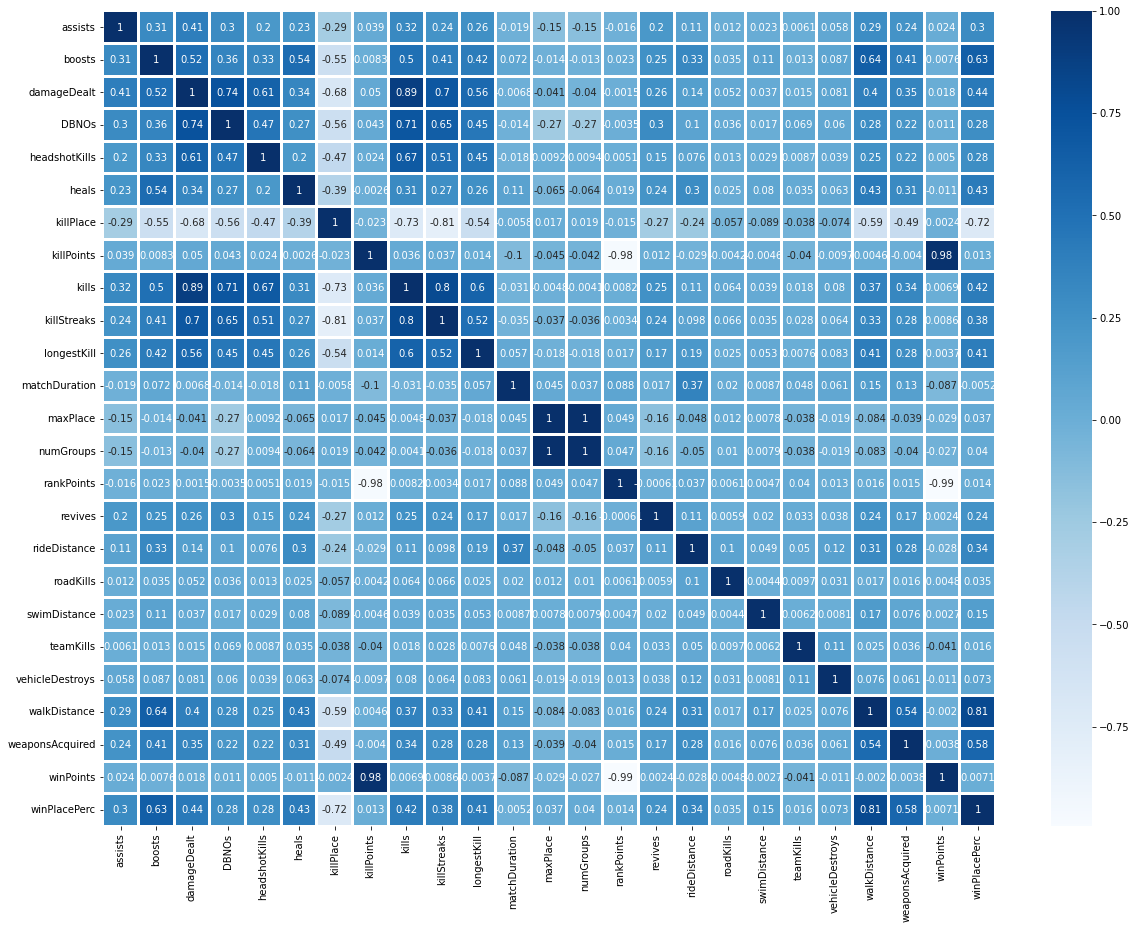

In [15]:
plt.subplots(figsize=(20,15))
sns.heatmap(train.corr(), annot=True, linewidths=2, cmap = 'Blues')

양의 상관관계
- walkDistance (0.81)
- boosts (0.63)
- weaponsAcquired (0.58)
<br><br>

음의 상관관계
- killPlace (-0.72)

### VIF

In [17]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
train = pd.read_csv('/Users/sanghyun/Desktop/Coding/PUBG_ML_Project/data/train_V2.csv')
train = reduce_mem_usage(train)

In [11]:
mydata3 = train.copy()

In [9]:
mydata3.head(5)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,longestKill,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,matchType2,cat_numGroups
0,0,0,0.00000,0,0,0,60,0,0.00000,0,0.000000,0.000000,0,244.75,1,0.444336,4,0
1,0,0,91.50000,0,0,0,57,0,0.00000,0,0.004501,11.039062,0,1434.00,5,0.640137,4,0
2,1,0,68.00000,0,0,0,47,0,0.00000,0,0.000000,0.000000,0,161.75,2,0.775391,2,1
3,0,0,32.90625,0,0,0,75,0,0.00000,0,0.000000,0.000000,0,202.75,3,0.166748,4,0
4,0,0,100.00000,0,0,0,45,1,58.53125,0,0.000000,0.000000,0,49.75,2,0.187500,1,2


In [18]:
feature = mydata3.drop('winPlacePerc', axis=1)
target = mydata3.winPlacePerc

pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(mydata3.values, idx) for idx in range(mydata3.shape[1])],
    "features": mydata3.columns,
})

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
X = mydata3[['killStreaks','kills']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

In [ ]:
X = mydata3[['maxPlace','numGroups','DBNOs','assists','weaponsAcquired','walkDistance']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

In [18]:
X = mydata3[['maxPlace','numGroups','DBNOs','assists','weaponsAcquired','walkDistance']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

           feature          VIF
0         maxPlace  1049.371675
1        numGroups  1042.673921
2            DBNOs     1.521727
3          assists     1.357949
4  weaponsAcquired     3.978879
5     walkDistance     2.931649


In [19]:
X = mydata3[['numGroups','DBNOs','assists','weaponsAcquired','walkDistance']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

           feature       VIF
0        numGroups  2.102238
1            DBNOs  1.521721
2          assists  1.357873
3  weaponsAcquired  3.944775
4     walkDistance  2.931409


In [20]:
X = mydata3[['maxPlace','DBNOs','assists','weaponsAcquired','walkDistance']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

           feature       VIF
0         maxPlace  2.115728
1            DBNOs  1.521686
2          assists  1.357924
3  weaponsAcquired  3.959988
4     walkDistance  2.931247


### EDA

#### matchType

In [21]:
train['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [22]:
pd.set_option('display.max_columns', 30)

train[(train['matchType'].str.contains('crash')==True)] # 6658 2인

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1093,c8ed6a171536e3,84748458aba82a,d4f1811cf6a04b,1,3,187.375,0,1,6,27,0,1,1,0.800781,904,crashfpp,50,45,1500,0,0.00,0,0.0,0,0,1342.000000,1,0,0.489746
1276,d3c4dd2e585d21,6af9bb6b56b722,16e6befa897b44,0,0,0.000,0,0,0,88,0,0,0,0.000000,892,crashfpp,47,45,1500,0,0.00,0,0.0,0,0,0.000000,0,0,0.000000
1790,28390372a2cc4f,c529d05da4597b,be945f2803814a,0,0,0.000,0,0,0,76,0,0,0,0.000000,915,crashfpp,50,50,1500,0,393.75,0,0.0,0,0,459.500000,0,0,0.204102
1905,fd39e397db5de4,67d1056e060313,ab05fc989cba70,0,2,0.000,0,0,0,44,0,0,0,0.000000,871,crashfpp,47,43,1500,0,6504.00,0,0.0,0,0,326.250000,2,0,0.652344
2111,1f2775b6f994ae,580347c80ae6a3,098b32c9c9ceb3,0,0,0.000,1,0,0,46,0,0,0,0.000000,905,crashfpp,36,33,1500,0,1124.00,0,0.0,1,0,1683.000000,2,0,0.371338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439168,f2b652c1c3480d,878b4c9a5c6724,f8dbb6134bf6fc,0,0,0.000,0,0,0,92,0,0,0,0.000000,916,crashfpp,49,48,1500,0,0.00,0,0.0,0,0,0.000000,0,0,0.000000
4440338,8df00ec3211cda,52d3feee3ff6d6,c35eb4e9d58f7c,2,0,220.750,0,1,0,18,0,1,1,2.421875,886,crashfpp,46,41,1500,0,1976.00,0,0.0,0,0,866.500000,2,0,1.000000
4440416,03242437424b00,d00910fbc45b1e,510cec3dea92d7,3,4,444.500,2,0,0,2,0,4,2,26.265625,882,crashfpp,31,30,1500,0,5152.00,2,0.0,0,0,23.109375,1,0,0.933105
4440956,9a366526fccde1,7172ba7ef85e3c,a0f8f127c472fc,2,6,219.375,1,0,1,14,0,1,1,1.194336,902,crashfpp,32,31,1500,0,4512.00,0,0.0,0,0,1059.000000,2,0,0.838867


In [23]:
pd.set_option('display.max_columns', 30)

train[(train['matchType'].str.contains('flare')==True)] #3223 4인

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1207,fb785deb59f2bc,4438f77ac9f2e6,33d976b454b843,0,4,577.0000,7,2,4,6,0,4,2,208.500000,1947,flaretpp,26,25,1500,1,2548.0000,0,0.0,0,1,2564.000000,6,0,0.799805
1524,b0fbbe07014fcd,7ce6194a5dd609,e330f44c528e6f,0,0,20.9375,0,0,0,55,0,0,0,0.000000,2031,flarefpp,17,17,1500,0,0.0000,0,0.0,0,0,13.640625,1,0,0.062500
6585,d2c938fa145684,c376a13f2593d4,306b7105f46fb1,0,6,159.7500,2,0,5,4,0,3,2,78.812500,1889,flarefpp,27,25,1500,0,4116.0000,0,0.0,0,0,2340.000000,6,0,0.807617
8033,7ec6701d1a9497,1e7b1e3440d76f,f1a007cdb3948e,0,0,0.0000,0,0,0,71,0,0,0,0.000000,1891,flarefpp,26,26,1500,0,0.0000,0,0.0,0,0,655.000000,10,0,0.239990
12845,4ac8d0521b049c,9abf85145ec8ba,4163d04f4beb17,0,2,56.6875,0,0,1,50,0,0,0,0.000000,1915,flaretpp,26,25,1500,0,5792.0000,0,0.0,0,0,1653.000000,4,0,0.560059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4435289,df3ab1c1b087fd,7312e4825719e0,1a452d3a8d3302,0,5,120.8750,1,0,11,25,0,1,1,166.875000,1808,flaretpp,26,26,1500,0,2314.0000,0,0.0,1,0,3072.000000,10,0,0.720215
4436960,fe7ac3372c0fc2,e6b4302f12b8ed,9bee5835506a78,0,1,36.5625,0,0,1,60,0,0,0,0.000000,1820,flaretpp,27,27,1500,0,0.0000,0,0.0,0,0,1005.000000,2,0,0.269287
4438287,76e9ab41368cc8,5385baa97a54b2,6a646d26225c2d,0,0,0.0000,0,0,4,60,0,0,0,0.000000,1944,flaretpp,24,23,1500,0,0.0007,0,0.0,0,0,2680.000000,4,0,0.478271
4440119,6b8d629cec6ae7,085a3f1a616a83,8fcb66d54bb1a2,0,4,362.5000,1,1,8,21,0,1,1,9.945312,1932,flaretpp,26,26,1500,0,4944.0000,0,0.0,0,0,1965.000000,5,0,0.600098


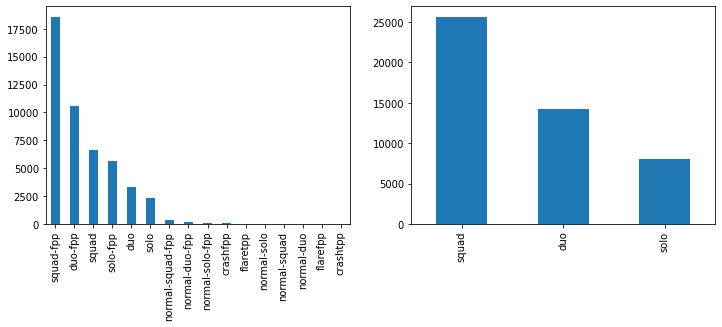

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

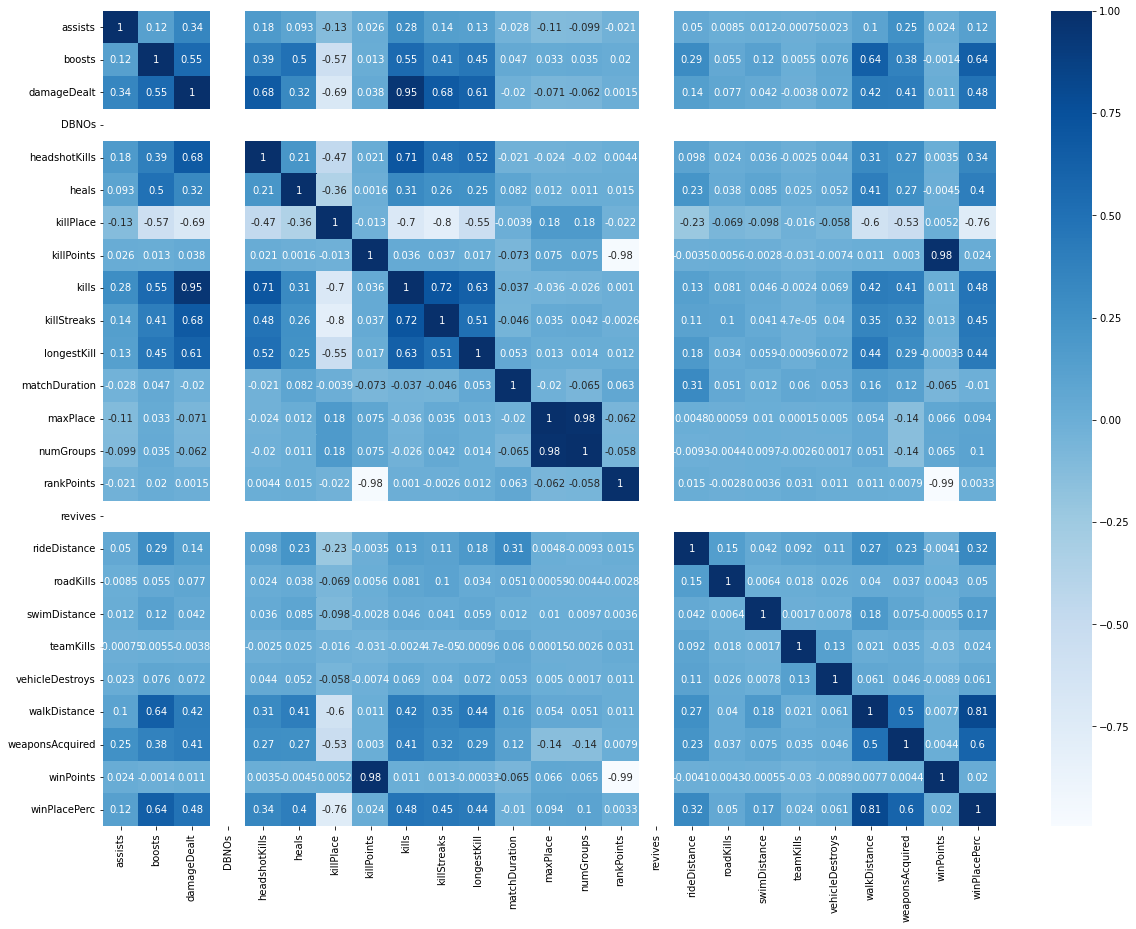

In [25]:
plt.subplots(figsize=(20,15))
sns.heatmap(train[train['matchType']=='solo'].corr(), annot=True, cmap='Blues')

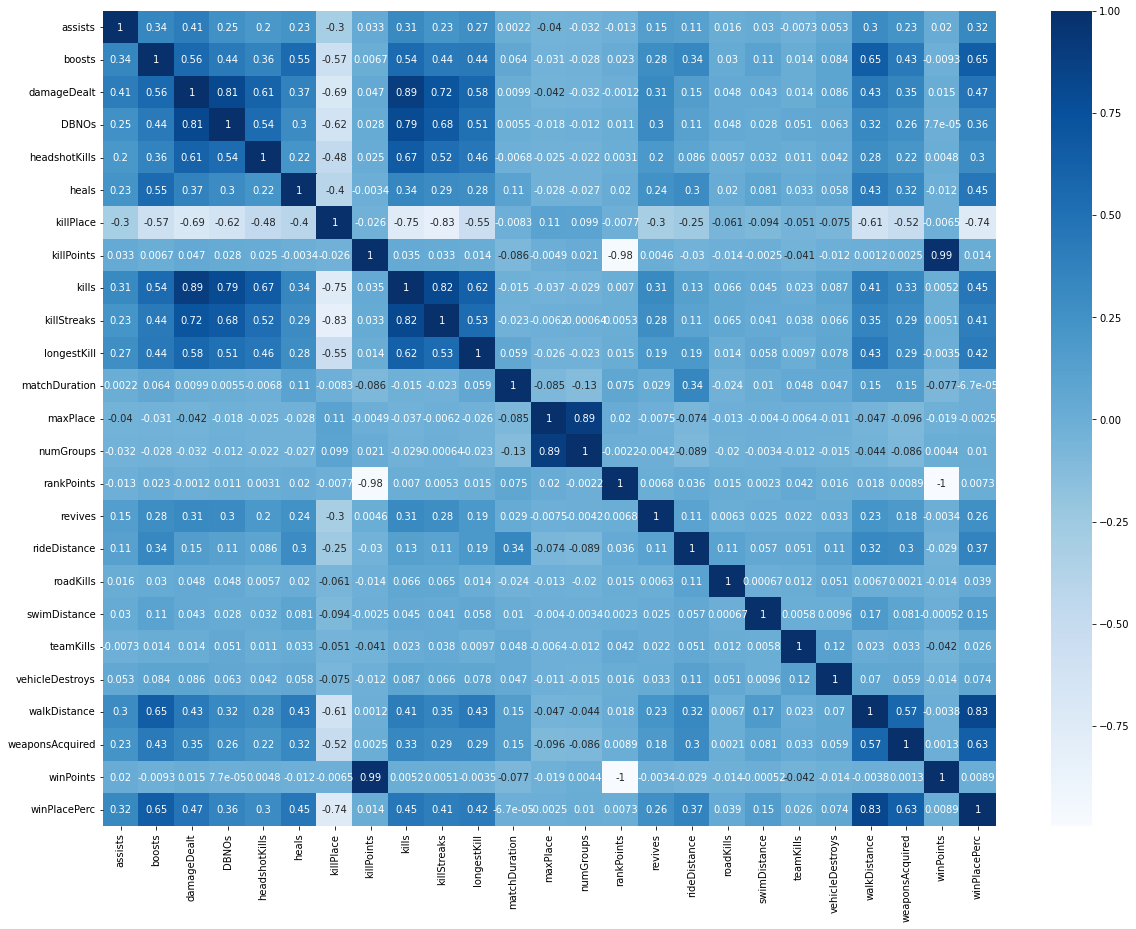

In [26]:
plt.subplots(figsize=(20,15))
sns.heatmap(train[train['matchType']=='duo'].corr(), annot=True, cmap='Blues')

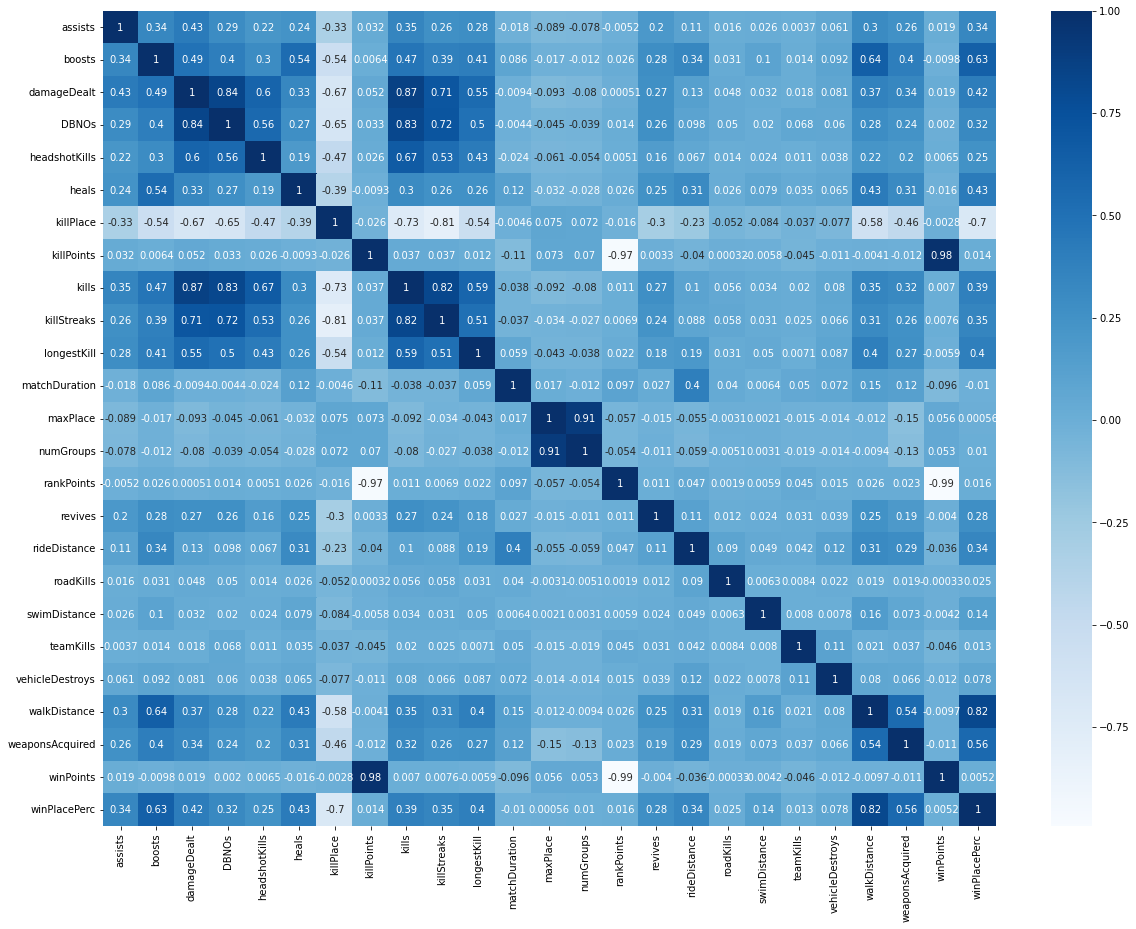

In [27]:
plt.subplots(figsize=(20,15))
sns.heatmap(train[train['matchType']=='squad'].corr(), annot=True, cmap='Blues')

#### Top 10

In [28]:
top10 = train[train["winPlacePerc"]>0.9]
print("TOP 10% overview\n")
print("Average number of kills: {:.1f}\nMinimum: {}\nThe best: {}\n95% of players within: {} kills." 
      .format(top10["kills"].mean(), top10["kills"].min(), top10["kills"].max(),top10["kills"].quantile(0.95)))

TOP 10% overview

Average number of kills: 2.6
Minimum: 0
The best: 72
95% of players within: 8.0 kills.


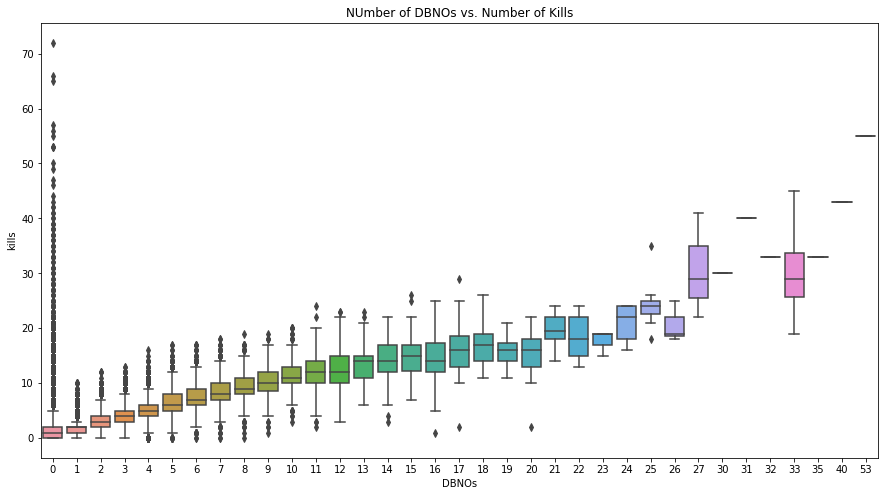

In [29]:
plt.figure(figsize=(15,8))
ax3 = sns.boxplot(x="DBNOs",y="kills", data = top10)
ax3.set_title("NUmber of DBNOs vs. Number of Kills")
plt.show()

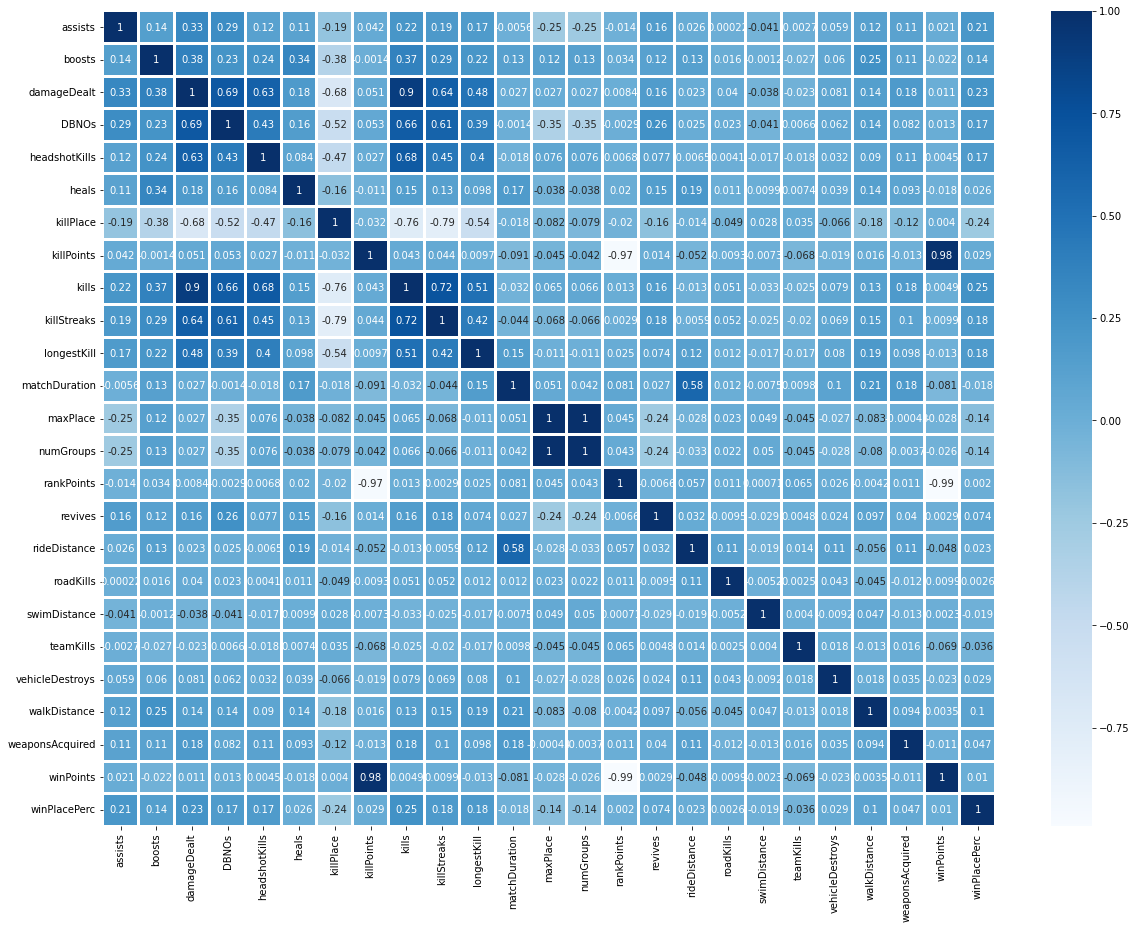

In [30]:
plt.subplots(figsize=(20,15))
sns.heatmap(top10.corr(), annot=True, linewidths=2, cmap = 'Blues')

## 전처리

In [31]:
# 내 담당 칼럼을 제외하고 모두 드랍

# Q)  조건 설정된 칼럼 제외한 모든 칼럼 drop하는 코드가 있을 것같은데..

mydata.drop(['Id'], axis=1, inplace=True)
mydata.drop(['groupId'], axis=1, inplace=True)
mydata.drop(['matchId'], axis=1, inplace=True)
mydata.drop(['assists'], axis=1, inplace=True)
mydata.drop(['boosts'], axis=1, inplace=True)
mydata.drop(['damageDealt'], axis=1, inplace=True)
mydata.drop(['DBNOs'], axis=1, inplace=True)
mydata.drop(['headshotKills'], axis=1, inplace=True)
mydata.drop(['heals'], axis=1, inplace=True)
mydata.drop(['killPlace'], axis=1, inplace=True)
mydata.drop(['killPoints'], axis=1, inplace=True)
mydata.drop(['kills'], axis=1, inplace=True)
mydata.drop(['killStreaks'], axis=1, inplace=True)
mydata.drop(['longestKill'], axis=1, inplace=True)
mydata.drop(['matchDuration'], axis=1, inplace=True)
mydata.drop(['maxPlace'], axis=1, inplace=True)
mydata.drop(['numGroups'], axis=1, inplace=True)
mydata.drop(['rankPoints'], axis=1, inplace=True)
mydata.drop(['revives'], axis=1, inplace=True)
mydata.drop(['roadKills'], axis=1, inplace=True)
mydata.drop(['teamKills'], axis=1, inplace=True)
mydata.drop(['winPoints'], axis=1, inplace=True)

mydata.head(5)

,matchType,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,squad-fpp,0.000000,0.000000,0,244.75,1,0.444336
1,squad-fpp,0.004501,11.039062,0,1434.00,5,0.640137
2,duo,0.000000,0.000000,0,161.75,2,0.775391
3,squad-fpp,0.000000,0.000000,0,202.75,3,0.166748
4,solo-fpp,0.000000,0.000000,0,49.75,2,0.187500


### matchType Feature Engineering

In [32]:
mydata['matchType']

0          squad-fpp
1          squad-fpp
2                duo
3          squad-fpp
4           solo-fpp
             ...    
4446961    squad-fpp
4446962         solo
4446963    squad-fpp
4446964    squad-fpp
4446965     solo-fpp
Name: matchType, Length: 4446966, dtype: object

In [34]:
## matchType 전처리


# matchType2라는 칼럼을 생성
mydata['matchType2'] = pd.NaT

# # row가 많아서 생기는 메모리 에러 무시하고 진행
# pd.set_option('mode.chained_assignment',  None)


# # squad, duo, solo 통합
# maplist = {
#     'squad' : 'squad',
#     'duo' : 'duo',
#     'solo' : 'solo'
# }

# for i in maplist:
#   mydata.matchType2[(mydata['matchType'].str.contains(i)==True)&(mydata['matchType2'].isnull())]=maplist.get(i)


# # solo ⮕ 1, duo ⮕ 2, squad ⮕ 4의 vector로 전환
# def convert(x):
#     if x == "squad":
#         return 4
#     elif x == "duo":
#         return 2
#     else:
#         return 1
    
# mydata['matchType2'] = mydata['matchType2'].map(convert)


# ## crash와 flare를 drop할 때
# # squad, duo, solo 통합
# maplist = {
#      'squad' : 'squad',
#      'duo' : 'duo',
#      'solo' : 'solo',
#      'crash' : 'dropT',
#      'flare' : 'dropT'
# }

# for i in maplist:
#   mydata.matchType2[(mydata['matchType'].str.contains(i)==True)&(mydata['matchType2'].isnull())]=maplist.get(i)

# mydata.drop(mydata[mydata['matchType']=='dropT'].index, inplace=True)

# # # solo ⮕ 1, duo ⮕ 2, squad ⮕ 4의 vector로 전환
# def convert(x):
#     if x == "squad":
#         return 4
#     elif x == "duo":
#         return 2
#     else:
#         return 1
    
# mydata['matchType2'] = mydata['matchType2'].map(convert)




## crash와 flare를 event mode로 처리할 때  _  채택


## matchType 전처리


# matchType2라는 칼럼을 생성


mydata['matchType2'] = pd.NaT
maplist = {
    'squad' : 'squad',
    'duo' : 'duo',
    'solo' : 'solo',
    'crash' : 'event',
    'flare' : 'event'
}

for i in maplist:
  mydata.matchType2[(mydata['matchType'].str.contains(i)==True)&(mydata['matchType2'].isnull())]=maplist.get(i)


# solo ⮕ 1, duo ⮕ 2, squad ⮕ 4, falre & crash ⮕ 0 으로 전환
def convert(x):
    if x == "squad":
        return 4
    elif x == "duo":
        return 2
    elif x == "solo":
        return 1
    else : 
        return 0
    
mydata['matchType2'] = mydata['matchType2'].map(convert)


# 기존의 matchType drop
mydata.drop(['matchType'], axis=1, inplace=True)

# matchType2 rename, reindex
mydata.rename(columns = {'matchType2':'matchType'}, inplace = True)
mydata = mydata.reindex(columns=['matchType','rideDistance', 'swimDistance','walkDistance','vehicleDestroys','weaponsAcquired','winPlacePerc'])

mydata.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,matchType,rideDistance,swimDistance,walkDistance,vehicleDestroys,weaponsAcquired,winPlacePerc
0,4,0.000000,0.000000,244.7500,0,1,0.444336
1,4,0.004501,11.039062,1434.0000,0,5,0.640137
2,2,0.000000,0.000000,161.7500,0,2,0.775391
3,4,0.000000,0.000000,202.7500,0,3,0.166748
4,1,0.000000,0.000000,49.7500,0,2,0.187500
5,4,0.000000,0.000000,34.6875,0,1,0.036987
6,4,0.000000,0.000000,13.5000,0,1,0.000000
7,1,2004.000000,0.000000,1089.0000,0,6,0.736816
8,4,0.000000,0.000000,800.0000,0,4,0.370361
9,4,0.000000,0.000000,65.6875,0,1,0.214355


In [35]:
print("* 데이터 타입, 데이터프레임 정보 확인")
print("----------------------------------------------------------------------")
mydata.info()
print()
print("* 데이터 칼럼별 결측값 확인")
print("----------------------------------------------------------------------")
mydata.isnull().sum()

* 데이터 타입, 데이터프레임 정보 확인
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   matchType        int64  
 1   rideDistance     float16
 2   swimDistance     float16
 3   walkDistance     float16
 4   vehicleDestroys  int8   
 5   weaponsAcquired  int16  
 6   winPlacePerc     float16
dtypes: float16(4), int16(1), int64(1), int8(1)
memory usage: 80.6 MB

* 데이터 칼럼별 결측값 확인
----------------------------------------------------------------------


matchType          0
rideDistance       0
swimDistance       0
walkDistance       0
vehicleDestroys    0
weaponsAcquired    0
winPlacePerc       1
dtype: int64

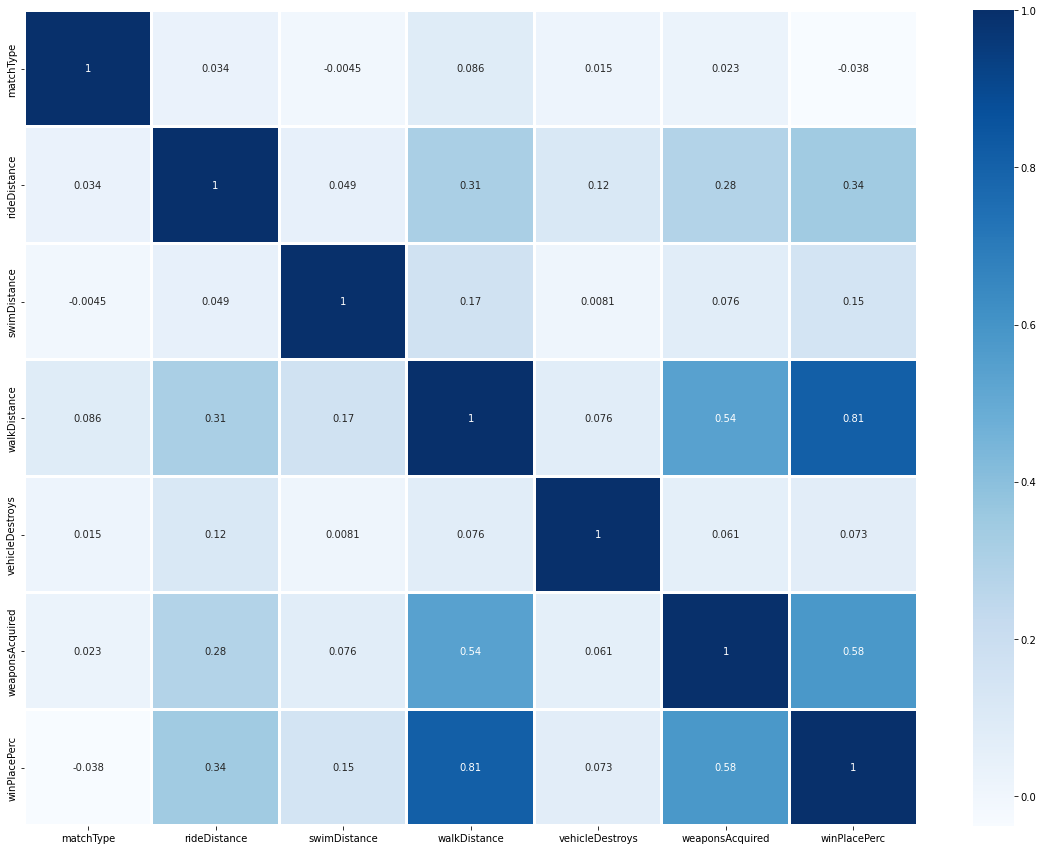

In [36]:
plt.subplots(figsize=(20,15))
sns.heatmap(mydata.corr(), annot=True, linewidths=2, cmap = 'Blues')

### Distance

In [37]:
# 거리
mydata['rideAndswim'] = mydata['rideDistance'] + mydata['swimDistance']
mydata['rideAndwalk'] = mydata['rideDistance'] + mydata['walkDistance']
mydata['swimAndwalk'] = mydata['swimDistance'] + mydata['walkDistance']
mydata['totalDistance'] = mydata['rideAndswim'] + mydata['walkDistance']

mydata = mydata.reindex(columns=['matchType','rideDistance', 'swimDistance','walkDistance','rideAndswim','rideAndwalk','swimAndwalk','totalDistance','vehicleDestroys','weaponsAcquired','winPlacePerc'])


mydata.head(10)

,matchType,rideDistance,swimDistance,walkDistance,rideAndswim,rideAndwalk,swimAndwalk,totalDistance,vehicleDestroys,weaponsAcquired,winPlacePerc
0,4,0.000000,0.000000,244.7500,0.000000,244.7500,244.7500,244.7500,0,1,0.444336
1,4,0.004501,11.039062,1434.0000,11.046875,1434.0000,1445.0000,1445.0000,0,5,0.640137
2,2,0.000000,0.000000,161.7500,0.000000,161.7500,161.7500,161.7500,0,2,0.775391
3,4,0.000000,0.000000,202.7500,0.000000,202.7500,202.7500,202.7500,0,3,0.166748
4,1,0.000000,0.000000,49.7500,0.000000,49.7500,49.7500,49.7500,0,2,0.187500
5,4,0.000000,0.000000,34.6875,0.000000,34.6875,34.6875,34.6875,0,1,0.036987
6,4,0.000000,0.000000,13.5000,0.000000,13.5000,13.5000,13.5000,0,1,0.000000
7,1,2004.000000,0.000000,1089.0000,2004.000000,3092.0000,1089.0000,3092.0000,0,6,0.736816
8,4,0.000000,0.000000,800.0000,0.000000,800.0000,800.0000,800.0000,0,4,0.370361
9,4,0.000000,0.000000,65.6875,0.000000,65.6875,65.6875,65.6875,0,1,0.214355


In [38]:
print("* 데이터 칼럼별 결측값 확인")
print("----------------------------------------------------------------------")
mydata.isnull().sum()

* 데이터 칼럼별 결측값 확인
----------------------------------------------------------------------


matchType          0
rideDistance       0
swimDistance       0
walkDistance       0
rideAndswim        0
rideAndwalk        0
swimAndwalk        0
totalDistance      0
vehicleDestroys    0
weaponsAcquired    0
winPlacePerc       1
dtype: int64

In [39]:
mydata.describe()

,matchType,rideDistance,swimDistance,walkDistance,rideAndswim,rideAndwalk,swimAndwalk,totalDistance,vehicleDestroys,weaponsAcquired,winPlacePerc
count,4.446966e+06,4.446966e+06,4446966.0,4446966.000,4.446966e+06,4446966.00,4446966.000,4446966.000,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.913056e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.918208e-03,3.660488e+00,NaN
std,1.223283e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.261157e-02,2.456544e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.0,0.000,0.000000e+00,0.00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.0,155.125,0.000000e+00,157.75,155.375,158.125,0.000000e+00,2.000000e+00,1.999512e-01
50%,4.000000e+00,0.000000e+00,0.0,685.500,0.000000e+00,787.00,687.000,788.000,0.000000e+00,3.000000e+00,4.582520e-01
75%,4.000000e+00,1.910095e-01,0.0,1976.000,1.092344e+02,2716.00,1985.000,2728.000,0.000000e+00,5.000000e+00,7.407227e-01
max,4.000000e+00,4.070400e+04,3824.0,25776.000,4.070400e+04,41280.00,26160.000,41280.000,5.000000e+00,2.360000e+02,1.000000e+00


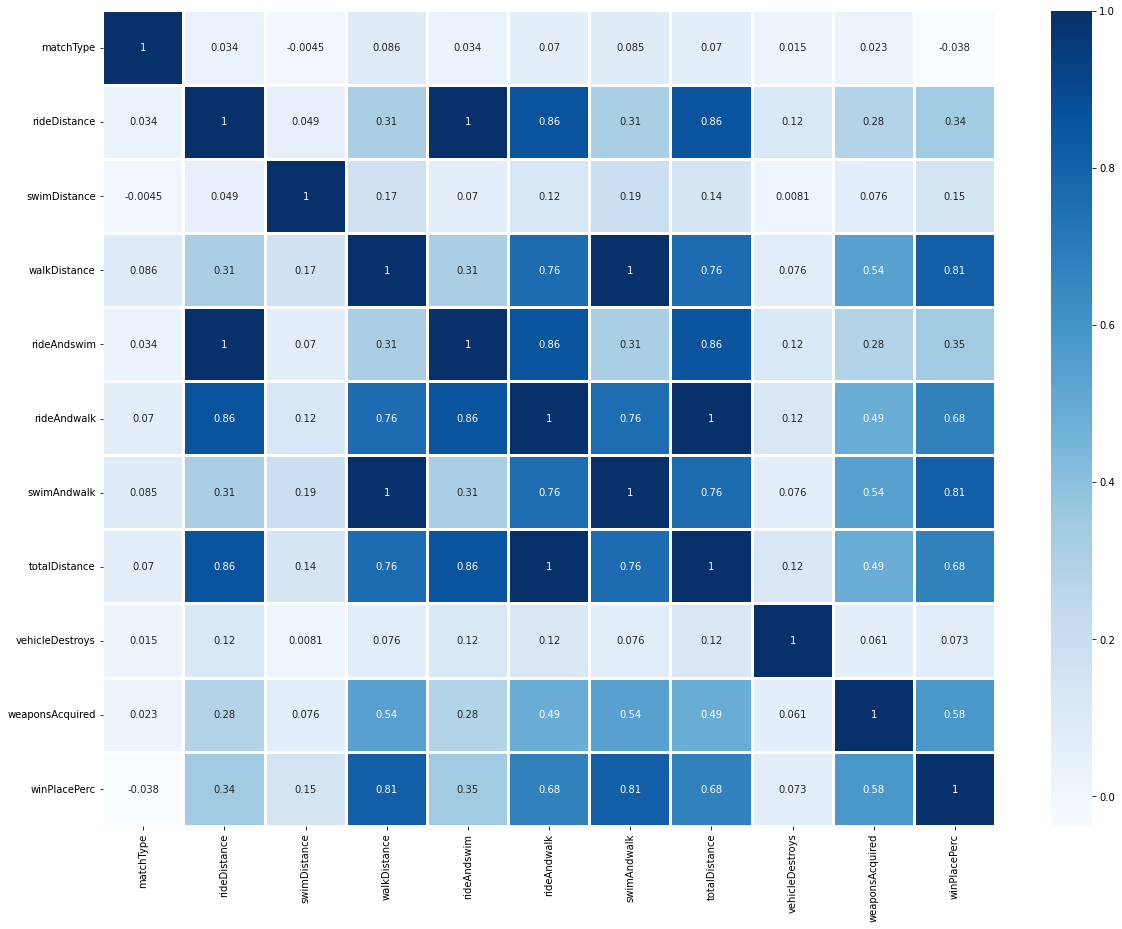

In [40]:
plt.subplots(figsize=(20,15))
sns.heatmap(mydata.corr(), annot=True, linewidths=2, cmap = 'Blues')

### Scaling

In [41]:
mydata.describe()

,matchType,rideDistance,swimDistance,walkDistance,rideAndswim,rideAndwalk,swimAndwalk,totalDistance,vehicleDestroys,weaponsAcquired,winPlacePerc
count,4.446966e+06,4.446966e+06,4446966.0,4446966.000,4.446966e+06,4446966.00,4446966.000,4446966.000,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.913056e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.918208e-03,3.660488e+00,NaN
std,1.223283e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.261157e-02,2.456544e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.0,0.000,0.000000e+00,0.00,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.0,155.125,0.000000e+00,157.75,155.375,158.125,0.000000e+00,2.000000e+00,1.999512e-01
50%,4.000000e+00,0.000000e+00,0.0,685.500,0.000000e+00,787.00,687.000,788.000,0.000000e+00,3.000000e+00,4.582520e-01
75%,4.000000e+00,1.910095e-01,0.0,1976.000,1.092344e+02,2716.00,1985.000,2728.000,0.000000e+00,5.000000e+00,7.407227e-01
max,4.000000e+00,4.070400e+04,3824.0,25776.000,4.070400e+04,41280.00,26160.000,41280.000,5.000000e+00,2.360000e+02,1.000000e+00


In [42]:
from sklearn.preprocessing import StandardScaler
# StandardScaler 선언 및 Fitting
sdscaler = StandardScaler()
sdscaler.fit(mydata)

# 데이터 변환
sdscaled_data = sdscaler.transform(mydata)

# 데이터 프레임으로 저장
sdscaled_data = pd.DataFrame(sdscaled_data)

In [43]:
sdscaled_data.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,-3.884035e-15,-1.200206e-14,-1.781457e-15,3.129959e-16,5.803915e-15,1.151950e-16,2.844365e-16,2.959729e-16,-5.379599e-15,-8.016567e-15,5.493439e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.381342e+00,-4.045240e-01,-1.478356e-01,-9.752605e-01,-4.070398e-01,-8.078279e-01,-9.745498e-01,-8.084051e-01,-8.549913e-02,-1.490097e+00,-1.538112e+00
25%,-7.463979e-01,-4.045240e-01,-1.478356e-01,-8.441870e-01,-4.070398e-01,-7.354354e-01,-8.438713e-01,-7.359742e-01,-8.549913e-02,-6.759448e-01,-8.876588e-01
50%,8.885465e-01,-4.045240e-01,-1.478356e-01,-3.960448e-01,-4.070398e-01,-4.466686e-01,-3.967470e-01,-4.474532e-01,-8.549913e-02,-2.688687e-01,-4.739089e-02
75%,8.885465e-01,-4.043965e-01,-1.478356e-01,6.943678e-01,-3.342247e-01,4.385616e-01,6.949385e-01,4.411848e-01,-8.549913e-02,5.452834e-01,8.715032e-01
max,8.885465e-01,2.676148e+01,1.252197e+02,2.080426e+01,2.672605e+01,1.813582e+01,2.102737e+01,1.810034e+01,5.390344e+01,9.457985e+01,1.714948e+00


In [44]:
sdscaled_data.head(10)

,0,1,2,3,4,5,6,7,8,9,10
0,0.888546,-0.404524,-0.147836,-0.768458,-0.407040,-0.695511,-0.768702,-0.696295,-0.085499,-1.083021,-0.092661
1,0.888546,-0.404521,0.214074,0.236403,-0.399676,-0.149756,0.240770,-0.146507,-0.085499,0.545283,0.544291
2,-0.746398,-0.404524,-0.147836,-0.838589,-0.407040,-0.733600,-0.838510,-0.734314,-0.085499,-0.675945,0.984280
3,0.888546,-0.404524,-0.147836,-0.803946,-0.407040,-0.714785,-0.804026,-0.715533,-0.085499,-0.268869,-0.995671
4,-1.563870,-0.404524,-0.147836,-0.933224,-0.407040,-0.784997,-0.932707,-0.785617,-0.085499,-0.675945,-0.928163
5,0.888546,-0.404524,-0.147836,-0.945951,-0.407040,-0.791910,-0.945376,-0.792516,-0.085499,-1.083021,-1.417790
6,0.888546,-0.404524,-0.147836,-0.963854,-0.407040,-0.801633,-0.963196,-0.802221,-0.085499,-1.083021,-1.538112
7,-1.563870,0.932953,-0.147836,-0.055106,0.928817,0.611110,-0.058644,0.607919,-0.085499,0.952359,0.858796
8,0.888546,-0.404524,-0.147836,-0.299298,-0.407040,-0.440703,-0.301708,-0.441956,-0.085499,0.138207,-0.333304
9,0.888546,-0.404524,-0.147836,-0.919758,-0.407040,-0.777683,-0.919303,-0.778316,-0.085499,-1.083021,-0.840801


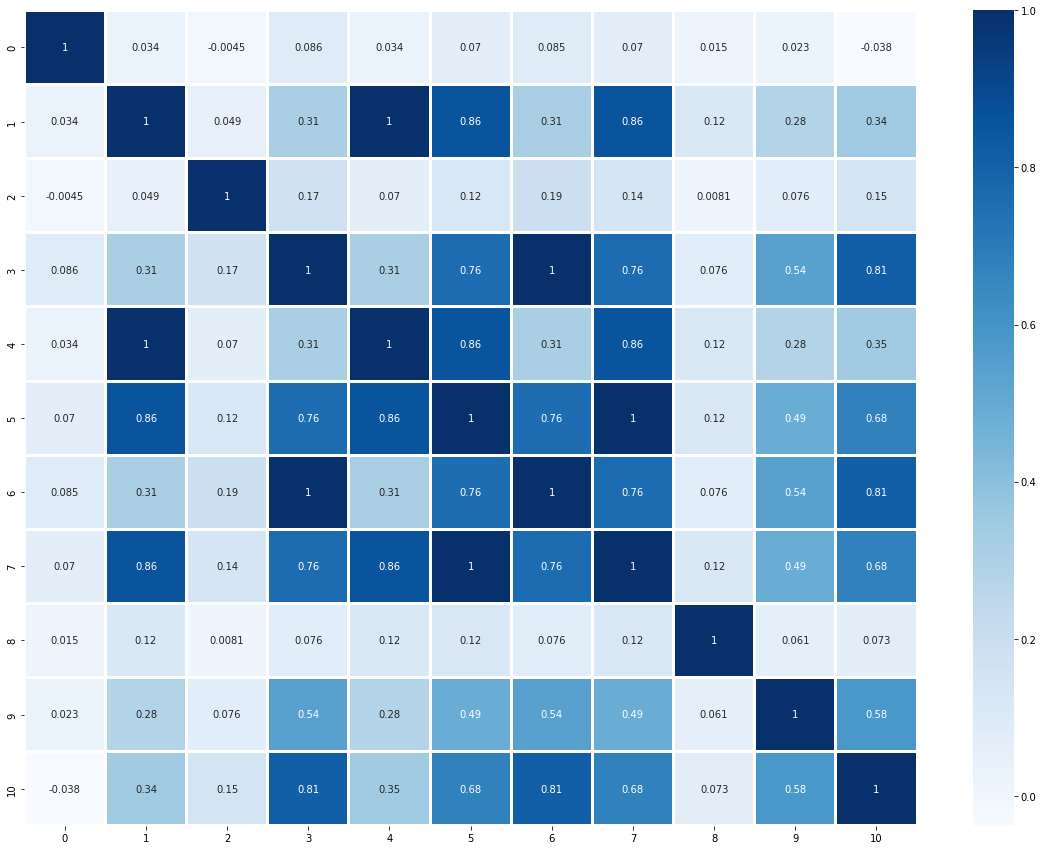

In [45]:
plt.subplots(figsize=(20,15))
sns.heatmap(sdscaled_data.corr(), annot=True, linewidths=2, cmap = 'Blues')

In [46]:
mydata.head(10)

,matchType,rideDistance,swimDistance,walkDistance,rideAndswim,rideAndwalk,swimAndwalk,totalDistance,vehicleDestroys,weaponsAcquired,winPlacePerc
0,4,0.000000,0.000000,244.7500,0.000000,244.7500,244.7500,244.7500,0,1,0.444336
1,4,0.004501,11.039062,1434.0000,11.046875,1434.0000,1445.0000,1445.0000,0,5,0.640137
2,2,0.000000,0.000000,161.7500,0.000000,161.7500,161.7500,161.7500,0,2,0.775391
3,4,0.000000,0.000000,202.7500,0.000000,202.7500,202.7500,202.7500,0,3,0.166748
4,1,0.000000,0.000000,49.7500,0.000000,49.7500,49.7500,49.7500,0,2,0.187500
5,4,0.000000,0.000000,34.6875,0.000000,34.6875,34.6875,34.6875,0,1,0.036987
6,4,0.000000,0.000000,13.5000,0.000000,13.5000,13.5000,13.5000,0,1,0.000000
7,1,2004.000000,0.000000,1089.0000,2004.000000,3092.0000,1089.0000,3092.0000,0,6,0.736816
8,4,0.000000,0.000000,800.0000,0.000000,800.0000,800.0000,800.0000,0,4,0.370361
9,4,0.000000,0.000000,65.6875,0.000000,65.6875,65.6875,65.6875,0,1,0.214355


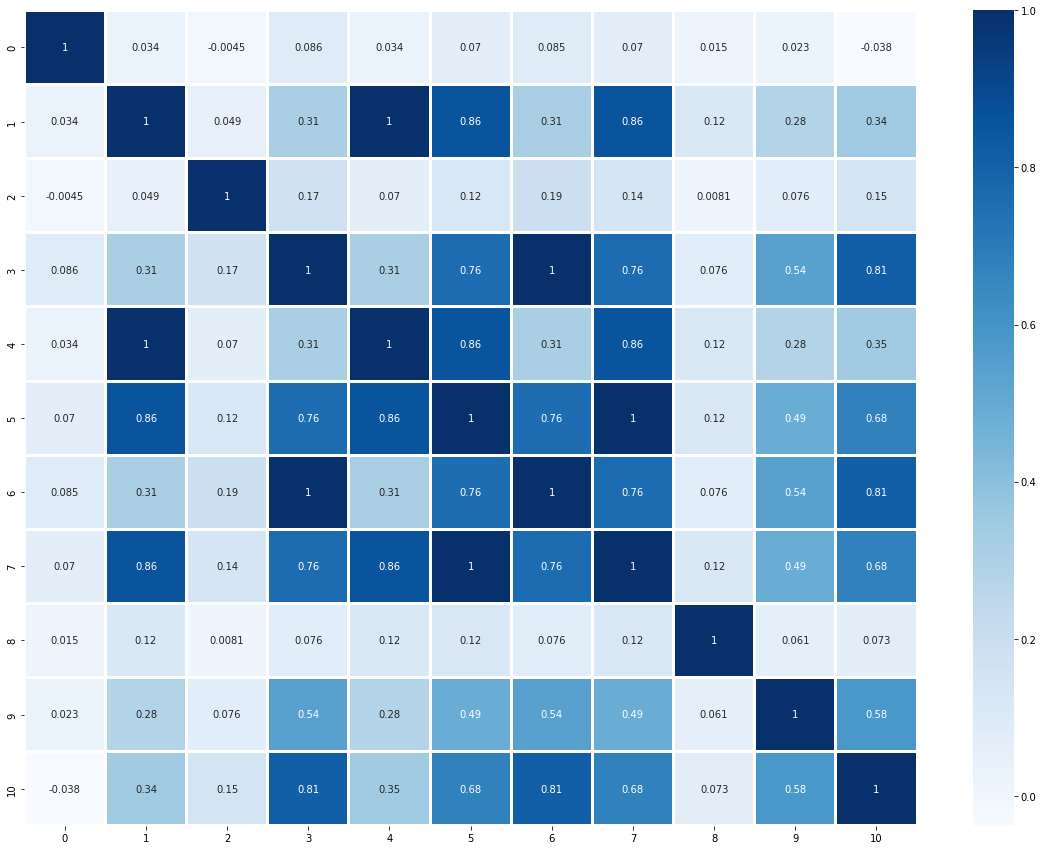

In [47]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaler.fit(mydata)

# 데이터 변환
mMscaled_data = mMscaler.transform(mydata)

# 데이터 프레임으로 저장
mMscaled_data = pd.DataFrame(mMscaled_data)

plt.subplots(figsize=(20,15))
sns.heatmap(mMscaled_data.corr(), annot=True, linewidths=2, cmap = 'Blues')

In [48]:
mMscaled_data.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,7.282640e-01,1.489082e-02,1.179217e-03,4.477878e-02,1.500160e-02,4.264373e-02,4.429385e-02,4.275296e-02,1.583642e-03,1.551054e-02,4.728200e-01
std,3.058208e-01,3.681072e-02,7.976546e-03,4.591469e-02,3.685537e-02,5.278814e-02,4.545058e-02,5.288558e-02,1.852231e-02,1.040908e-02,3.074029e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e-01,0.000000e+00,0.000000e+00,6.018195e-03,0.000000e+00,3.821463e-03,5.939411e-03,3.830547e-03,0.000000e+00,8.474576e-03,1.999512e-01
50%,1.000000e+00,0.000000e+00,0.000000e+00,2.659451e-02,0.000000e+00,1.906492e-02,2.626147e-02,1.908915e-02,0.000000e+00,1.271186e-02,4.582520e-01
75%,1.000000e+00,4.692647e-06,0.000000e+00,7.666046e-02,2.683628e-03,6.579457e-02,7.587920e-02,6.608527e-02,0.000000e+00,2.118644e-02,7.407227e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [49]:
sdscaled_data.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,-3.884035e-15,-1.200206e-14,-1.781457e-15,3.129959e-16,5.803915e-15,1.151950e-16,2.844365e-16,2.959729e-16,-5.379599e-15,-8.016567e-15,5.493439e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.381342e+00,-4.045240e-01,-1.478356e-01,-9.752605e-01,-4.070398e-01,-8.078279e-01,-9.745498e-01,-8.084051e-01,-8.549913e-02,-1.490097e+00,-1.538112e+00
25%,-7.463979e-01,-4.045240e-01,-1.478356e-01,-8.441870e-01,-4.070398e-01,-7.354354e-01,-8.438713e-01,-7.359742e-01,-8.549913e-02,-6.759448e-01,-8.876588e-01
50%,8.885465e-01,-4.045240e-01,-1.478356e-01,-3.960448e-01,-4.070398e-01,-4.466686e-01,-3.967470e-01,-4.474532e-01,-8.549913e-02,-2.688687e-01,-4.739089e-02
75%,8.885465e-01,-4.043965e-01,-1.478356e-01,6.943678e-01,-3.342247e-01,4.385616e-01,6.949385e-01,4.411848e-01,-8.549913e-02,5.452834e-01,8.715032e-01
max,8.885465e-01,2.676148e+01,1.252197e+02,2.080426e+01,2.672605e+01,1.813582e+01,2.102737e+01,1.810034e+01,5.390344e+01,9.457985e+01,1.714948e+00


### vehicleDestroys

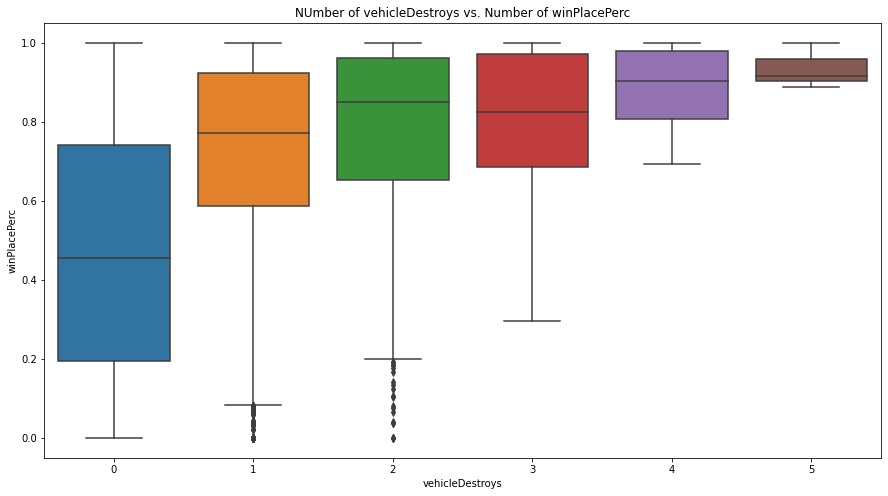

In [50]:
plt.figure(figsize=(15,8))
ax4 = sns.boxplot(x="vehicleDestroys",y="winPlacePerc", data = mydata)
ax4.set_title("NUmber of vehicleDestroys vs. Number of winPlacePerc")
plt.show()

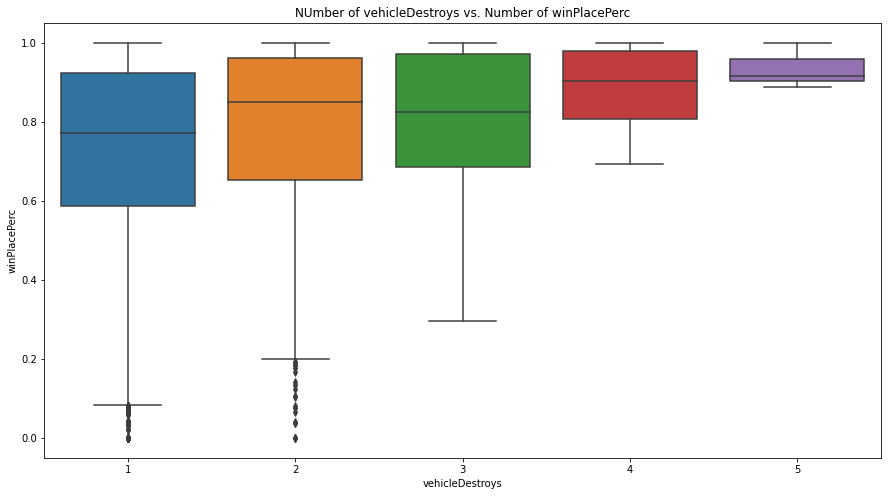

In [51]:
testdata = mydata.drop(mydata[mydata['vehicleDestroys']==0].index)

plt.figure(figsize=(15,8))
ax5 = sns.boxplot(x="vehicleDestroys",y="winPlacePerc", data = testdata)
ax5.set_title("NUmber of vehicleDestroys vs. Number of winPlacePerc")
plt.show()

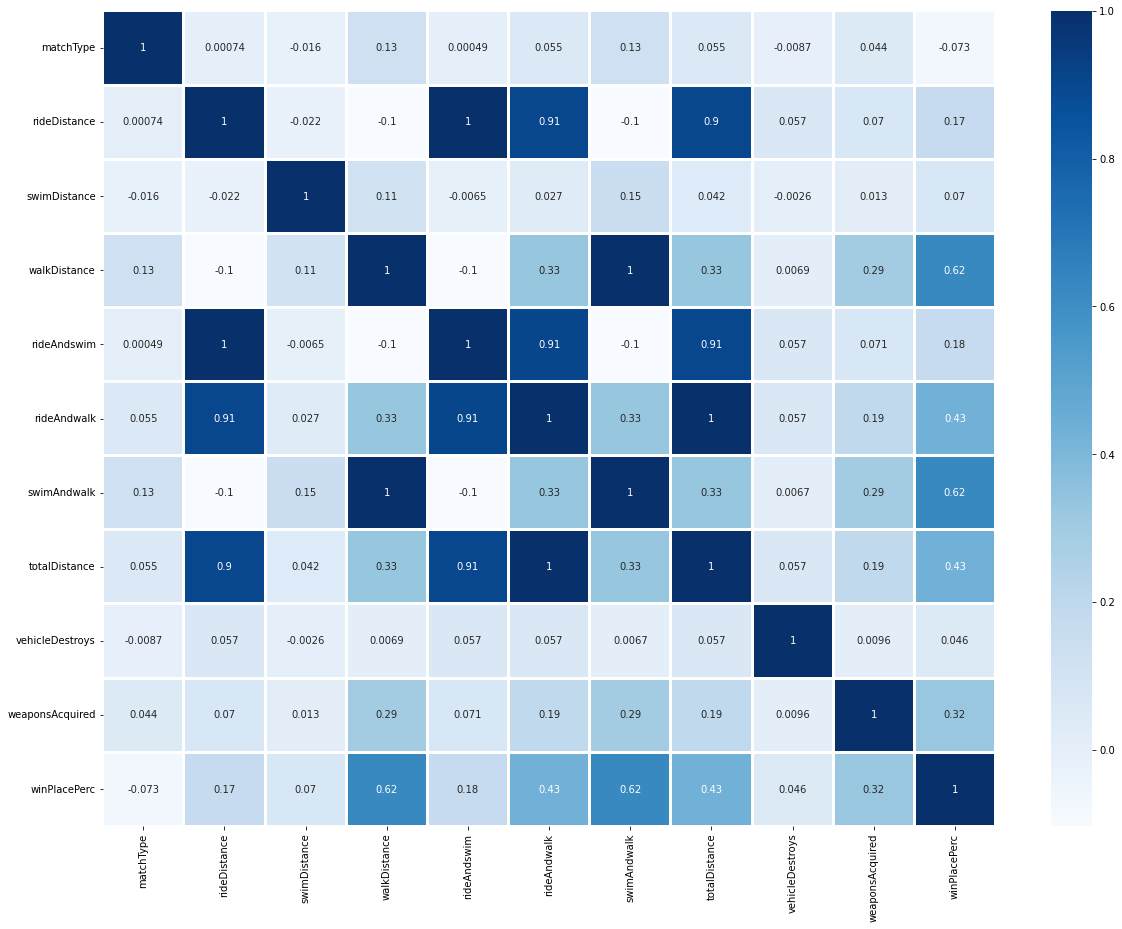

In [52]:
plt.subplots(figsize=(20,15))
sns.heatmap(testdata.corr(), annot=True, linewidths=2, cmap = 'Blues')

boxplot를 보면 높은 winPlacePerc에 box가 위치함.  
전체적인 분포와 mean값이 타겟값의 상단에 위치한 구조라 꽤 큰 상관계수를 보일 것이라 생각함.   
하지만, 생각보다 상관계수가 낮음.   

혹, vehicleDestroys가 0인 row들 때문인가 싶어서 제외하고 실행해 봤음   
그랬을 때, 기존 0.073에서 0.046으로 오히려 내려감   
????

# maxPlace와 numGroups에 대한 Feature Engineering

## dataset 불러오기

In [53]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [54]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
train = pd.read_csv('/content/drive/MyDrive/00.이어드림/Project/modelingPUBG/data/original_data/train_V2.csv')
train = reduce_mem_usage(train)

## 결측치 처리

In [57]:
data = train.copy()
data2 = train.copy()
data3 = train.copy()
data4 = train.copy()

data = data.drop(columns=['Id', 'groupId', 'matchId', 'rankPoints', 'roadKills', 'matchDuration', 'teamKills'])
data2 = data2.drop(columns=['Id', 'groupId', 'matchId', 'rankPoints', 'roadKills', 'matchDuration', 'teamKills'])
data3 = data3.drop(columns=['Id', 'groupId', 'matchId', 'rankPoints', 'roadKills', 'matchDuration', 'teamKills', 'killPoints', 'winPoints', 'maxPlace','matchType'])
data4 = data4.drop(columns=['Id', 'groupId', 'matchId', 'rankPoints', 'roadKills', 'matchDuration', 'teamKills', 'killPoints', 'winPoints','matchType'])  

In [58]:
data = data.dropna()
data2 = data2.dropna()
data3 = data3.dropna()

In [59]:
data['matchType2'] = pd.NaT

maplist = {
    'squad' : 'squad',
    'duo' : 'duo',
    'solo' : 'solo',
    'crash' : 'event',
    'flare' : 'event'
}

for i in maplist:
  data.matchType2[(data['matchType'].str.contains(i)==True)&(data['matchType2'].isnull())]=maplist.get(i)


# solo ⮕ 1, duo ⮕ 2, squad ⮕ 4, falre & crash ⮕ 0 으로 전환
def convert(x):
    if x == "squad":
        return 4
    elif x == "duo":
        return 2
    elif x == "solo":
        return 1
    else : 
        return 0
    
data['matchType2'] = data['matchType2'].map(convert)


# 기존의 matchType drop
data.drop(['matchType'], axis=1, inplace=True)

# matchType2 rename, reindex
data.rename(columns = {'matchType2':'matchType'}, inplace = True)

data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchType
0,0,0,0.000000,0,0,0,60,1241,0,0,0.00000,28,26,0,0.000000,0.000000,0,244.7500,1,1466,0.444336,4
1,0,0,91.500000,0,0,0,57,0,0,0,0.00000,26,25,0,0.004501,11.039062,0,1434.0000,5,0,0.640137,4
2,1,0,68.000000,0,0,0,47,0,0,0,0.00000,50,47,0,0.000000,0.000000,0,161.7500,2,0,0.775391,2
3,0,0,32.906250,0,0,0,75,0,0,0,0.00000,31,30,0,0.000000,0.000000,0,202.7500,3,0,0.166748,4
4,0,0,100.000000,0,0,0,45,0,1,1,58.53125,97,95,0,0.000000,0.000000,0,49.7500,2,0,0.187500,1
5,0,0,100.000000,1,1,0,44,0,1,1,18.43750,28,28,0,0.000000,0.000000,0,34.6875,1,0,0.036987,4
6,0,0,0.000000,0,0,0,96,1262,0,0,0.00000,28,28,0,0.000000,0.000000,0,13.5000,1,1497,0.000000,4
7,0,0,8.539062,0,0,0,48,1000,0,0,0.00000,96,92,0,2004.000000,0.000000,0,1089.0000,6,1500,0.736816,1
8,0,0,51.593750,0,0,0,64,0,0,0,0.00000,28,27,0,0.000000,0.000000,0,800.0000,4,0,0.370361,4
9,0,0,37.281250,0,0,0,74,0,0,0,0.00000,29,27,0,0.000000,0.000000,0,65.6875,1,0,0.214355,4


In [60]:
data2['matchType2'] = pd.NaT

maplist = {
    'squad' : 'squad',
    'duo' : 'duo',
    'solo' : 'solo',
    'crash' : 'event',
    'flare' : 'event'
}

for i in maplist:
  data2.matchType2[(data2['matchType'].str.contains(i)==True)&(data2['matchType2'].isnull())]=maplist.get(i)


# solo ⮕ 1, duo ⮕ 2, squad ⮕ 4, falre & crash ⮕ 0 으로 전환
def convert(x):
    if x == "squad":
        return 4
    elif x == "duo":
        return 2
    elif x == "solo":
        return 1
    else : 
        return 0
    
data2['matchType2'] = data2['matchType2'].map(convert)


# 기존의 matchType drop
data2.drop(['matchType'], axis=1, inplace=True)

# matchType2 rename, reindex
data2.rename(columns = {'matchType2':'matchType'}, inplace = True)

data2.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchType
0,0,0,0.000000,0,0,0,60,1241,0,0,0.00000,28,26,0,0.000000,0.000000,0,244.7500,1,1466,0.444336,4
1,0,0,91.500000,0,0,0,57,0,0,0,0.00000,26,25,0,0.004501,11.039062,0,1434.0000,5,0,0.640137,4
2,1,0,68.000000,0,0,0,47,0,0,0,0.00000,50,47,0,0.000000,0.000000,0,161.7500,2,0,0.775391,2
3,0,0,32.906250,0,0,0,75,0,0,0,0.00000,31,30,0,0.000000,0.000000,0,202.7500,3,0,0.166748,4
4,0,0,100.000000,0,0,0,45,0,1,1,58.53125,97,95,0,0.000000,0.000000,0,49.7500,2,0,0.187500,1
5,0,0,100.000000,1,1,0,44,0,1,1,18.43750,28,28,0,0.000000,0.000000,0,34.6875,1,0,0.036987,4
6,0,0,0.000000,0,0,0,96,1262,0,0,0.00000,28,28,0,0.000000,0.000000,0,13.5000,1,1497,0.000000,4
7,0,0,8.539062,0,0,0,48,1000,0,0,0.00000,96,92,0,2004.000000,0.000000,0,1089.0000,6,1500,0.736816,1
8,0,0,51.593750,0,0,0,64,0,0,0,0.00000,28,27,0,0.000000,0.000000,0,800.0000,4,0,0.370361,4
9,0,0,37.281250,0,0,0,74,0,0,0,0.00000,29,27,0,0.000000,0.000000,0,65.6875,1,0,0.214355,4


In [61]:
print("* 데이터 타입, 데이터프레임 정보 확인")
print("----------------------------------------------------------------------")
data.info()
print()
print("* 데이터 칼럼별 결측값 확인")
print("----------------------------------------------------------------------")
data.isnull().sum()
print('\n\n')
print("* 데이터 타입, 데이터프레임 정보 확인")
print("----------------------------------------------------------------------")
data2.info()
print()
print("* 데이터 칼럼별 결측값 확인")
print("----------------------------------------------------------------------")
data2.isnull().sum()

* 데이터 타입, 데이터프레임 정보 확인
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 22 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int8   
 1   boosts           int8   
 2   damageDealt      float16
 3   DBNOs            int8   
 4   headshotKills    int8   
 5   heals            int8   
 6   killPlace        int8   
 7   killPoints       int16  
 8   kills            int8   
 9   killStreaks      int8   
 10  longestKill      float16
 11  maxPlace         int8   
 12  numGroups        int8   
 13  revives          int8   
 14  rideDistance     float16
 15  swimDistance     float16
 16  vehicleDestroys  int8   
 17  walkDistance     float16
 18  weaponsAcquired  int16  
 19  winPoints        int16  
 20  winPlacePerc     float16
 21  matchType        int64  
dtypes: float16(6), int16(3), int64(1), int8(12)
memory usage: 195.1 MB



assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
maxPlace           0
numGroups          0
revives            0
rideDistance       0
swimDistance       0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
matchType          0
dtype: int64

## Tracking

In [62]:
print(np.sum(data.maxPlace == data.numGroups))
print(np.sum(data.maxPlace < data.numGroups))
print(np.sum(data.maxPlace > data.numGroups))

1241089
0
3205876


In [63]:
# pd.set_option('display.max_columns', 5)

pd.options.display.float_format = '{:.5f}'.format

data.describe()


## maxPlace는 결국 

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchType
count,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000,4446965.00000
mean,0.23381,1.10691,NaN,0.65788,0.22682,1.37015,47.59936,505.00616,0.92478,0.54396,NaN,44.50468,43.00760,0.16466,NaN,NaN,0.00792,NaN,3.66049,606.46027,NaN,2.91306
std,0.58857,1.71579,NaN,1.14574,0.60216,2.67998,27.46293,627.50492,1.55844,0.71097,NaN,23.82810,23.28949,0.47217,NaN,NaN,0.09261,NaN,2.45654,739.70047,0.00000,1.22328
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,24.00000,0.00000,0.00000,0.00000,0.00000,28.00000,27.00000,0.00000,0.00000,0.00000,0.00000,155.12500,2.00000,0.00000,0.19995,2.00000
50%,0.00000,0.00000,84.25000,0.00000,0.00000,0.00000,47.00000,0.00000,0.00000,0.00000,0.00000,30.00000,30.00000,0.00000,0.00000,0.00000,0.00000,685.50000,3.00000,0.00000,0.45825,4.00000
75%,0.00000,2.00000,186.00000,1.00000,0.00000,2.00000,71.00000,1172.00000,1.00000,1.00000,21.31250,49.00000,47.00000,0.00000,0.19104,0.00000,0.00000,1976.00000,5.00000,1495.00000,0.74072,4.00000
max,22.00000,33.00000,6616.00000,53.00000,64.00000,80.00000,101.00000,2170.00000,72.00000,20.00000,1094.00000,100.00000,100.00000,39.00000,40704.00000,3824.00000,5.00000,25776.00000,236.00000,2013.00000,1.00000,4.00000


In [64]:
data['maxPlace'].values

array([28, 26, 50, ..., 28, 26, 98], dtype=int8)

In [65]:
data[(data.maxPlace < 0)]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchType


In [66]:
len(data['maxPlace'])

4446965

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


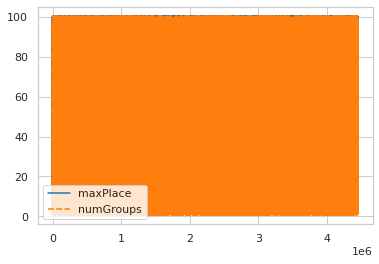

In [67]:
sns.set_theme(style="whitegrid")

sns.lineplot(data=data.loc[:,['maxPlace','numGroups']], palette="tab10", linewidth=2.5)

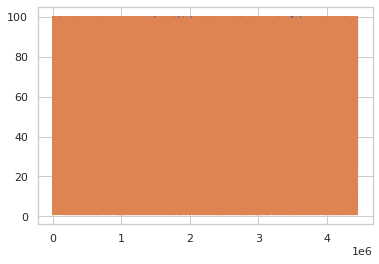

In [68]:
plt.plot(data['maxPlace'])
plt.plot(data['numGroups'])

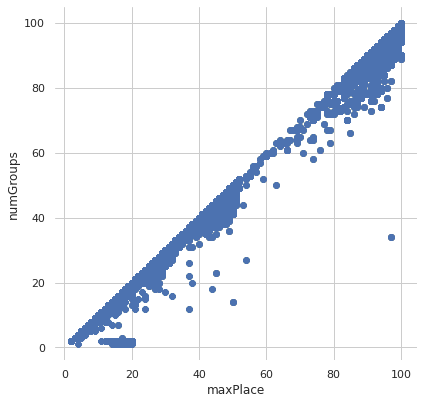

In [69]:
sns.set_theme(style="whitegrid")

# Load the example diamonds dataset
diamonds = data

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="maxPlace", y="numGroups",
                palette="ch:r=-.2,d=.3_r",
                linewidth=0,
                data=diamonds, ax=ax)

In [70]:
pd.set_option('display.max_columns', 30)

data[(data['maxPlace']>=90)&(data['numGroups']<=40)]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchType
29680,0,0,100.00000,0,0,0,18,0,1,1,40.03125,97,34,0,0.00000,0.00000,0,79.93750,2,0,0.28125,1
61381,0,0,0.00000,0,0,0,41,0,0,0,0.00000,97,34,0,0.00000,0.00000,0,619.00000,0,0,0.28125,1
72990,0,0,23.50000,0,0,1,11,0,1,1,12.50000,97,34,0,0.00000,0.00000,0,116.37500,4,0,0.28125,1
119749,0,0,0.00000,0,0,0,59,0,0,0,0.00000,97,34,0,0.00000,0.00000,0,153.12500,3,0,0.28125,1
132197,0,0,0.00000,0,0,0,43,0,0,0,0.00000,97,34,0,0.00000,0.00000,0,48.43750,2,0,0.28125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4254525,0,0,0.00000,0,0,0,74,0,0,0,0.00000,97,34,0,0.00000,0.00000,0,75.50000,1,0,0.28125,1
4389410,0,0,0.00000,0,0,0,61,0,0,0,0.00000,97,34,0,0.00000,0.00000,0,122.18750,3,0,0.28125,1
4402780,0,0,12.96094,0,0,0,96,0,0,0,0.00000,97,34,0,0.00000,0.00000,0,0.00000,0,0,0.01040,1
4425855,0,0,108.00000,0,0,0,4,0,2,2,15.67969,97,34,0,0.00000,0.00000,0,124.18750,3,0,0.28125,1


## Modeling

### 기존의 ML

In [71]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [72]:
## maxPlace Drop O
# drop : 'Id', 'groupId', 'matchId', 'rankPoints', 'roadKills', 'matchDuration', 'teamKills', 'killPoints', 'winPoints', 'maxPlace','matchType'

X = data3.drop(columns='winPlacePerc')
y = data3['winPlacePerc']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3557572, 17), (889393, 17), (3557572,), (889393,))

In [73]:
model = LGBMRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_absolute_error(y_test, pred)

0.06408375837403721

In [74]:
## maxPlace Drop X
# drop : 'Id', 'groupId', 'matchId', 'rankPoints', 'roadKills', 'matchDuration', 'teamKills', 'killPoints', 'winPoints','matchType'

X = data4.drop(columns='winPlacePerc')
y = data4['winPlacePerc']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3557572, 18), (889394, 18), (3557572,), (889394,))

In [75]:
model = LGBMRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_absolute_error(y_test, pred)

0.473042242613814

maxPlace를 Drop 했을 때 0.06<br>
maxPlace를 Drop 안했을 때 0.47<br>
⮕ maxPlace를 Drop해야한다.

### 가설1

**Why?**
- maxPlace를 Drop한 것과 안한것이 왜 저렇게 큰 차이를 보일까?

<br>

**How?**
- maxPlace의 outlayer를 제거한다면 maxPlace를 Drop한 값과 LGBM이 같을 것이다.

In [76]:
## maxPlace 이상치 제거 X
# drop : 'Id', 'groupId', 'matchId', 'rankPoints', 'roadKills', 'matchDuration', 'teamKills'

X = data2.drop(columns='winPlacePerc')
y = data2['winPlacePerc']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3557572, 21), (889393, 21), (3557572,), (889393,))

In [77]:
model = LGBMRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_absolute_error(y_test, pred)

0.06330111985584375

In [78]:
## maxPlace 이상치 제거 O
# drop : 'Id', 'groupId', 'matchId', 'rankPoints', 'roadKills', 'matchDuration', 'teamKills'

data = data.drop(data[(data['maxPlace']>=90)&(data['numGroups']<=40)].index)

X = data.drop(columns='winPlacePerc')
y = data['winPlacePerc']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


## LGBM의 값이 0.47 근사치가 나올 경우 가설이 맞음

((3557494, 21), (889374, 21), (3557494,), (889374,))

In [79]:
model = LGBMRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_absolute_error(y_test, pred)

## LGBM의 값이 기존과 동일하기 때문에 가설 기각

0.06342057152102139

maxPlace의 outlayer를 제거한다고 해도, 큰 차이는 없음.<br>
⮕ 가설 기각. 다른 기준값이 필요함

# 1차 정리

- maxPlace에 대한 LGBM값의 큰 변동은 초기 관측 오류로 결론
- 회의와 각자 전처리를 통해서 업데이트한 파일로 모델링을 할 경우, 대략적인 성능은 좋아지지만, 일부 살려야하는 칼럼들을 확인
- corr이 모델 성능 향상의 절대적인 지표가 될 수 없음을 확인. <ins>아웃라이어로 판단되지 않는다면 피쳐들을 조합하여 새로운 피쳐를 만드는 등의 시도</ins>를 해봐도 좋을 것으로 보임
<br><br>
**To do**
- distance를 기준으로 한 Feature Engineering
- kaggle data를 통해서 레퍼런스 확인
- LGBM 이후에도 많은 모델을 돌려볼 것
- (희망사항) 프로젝트 막바지에는 최신 논문에 기입된 모델을 돌려보는 것도 좋아보임